<a href="https://colab.research.google.com/github/samuramirez/cellmigration/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation one class (cell)

##Mount Google Drive, authenticate SDK, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Installing and loading packages 

In [ ]:
#!nvidia-smi

In [ ]:
import pandas as pd
#pip install --upgrade pandas

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 230kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101


In [ ]:
import torch
print(torch.__version__)


1.7.1


In [ ]:
print(torch.version.cuda)

10.2


In [ ]:
torch.cuda.is_available()

True

In [ ]:
#torch.cuda.get_device_name(0)

In [ ]:
#!pip install -q torch==1.7.0 torchvision

In [ ]:
#!pip install fastai==2.0.13 --no-deps


In [ ]:
#!pip install fastcore==1.0.13
!pip install fastcore

     |████████████████████████████████| 61kB 5.6MB/s 


In [ ]:
import fastcore


In [ ]:
#!pip install -Uqq fastbook

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 9.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai
fastai.__version__

'2.4'

In [ ]:
#import fastbook
#fastbook.setup_book()

In [ ]:
print(fastcore.__version__)


1.3.20


In [ ]:
from fastai.vision.all import *

In [ ]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
import os
import numpy as np
from pathlib import Path
import re
import ntpath


# Preparing data to train only on cell (from combined nuc-memb masks)

###Load masks for training

In [ ]:
training_masks_path='cellmbucket/training_datasets/110619_bleb_nuc_memb_masks' #@param
maskdir='training_masks/' #@param
#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param


In [ ]:
!mkdir {maskdir} 

In [ ]:
!gsutil -m cp -r gs://{training_masks_path} /{local_folder}

Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t1.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t101.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t26.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t51.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t1.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t76.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t26.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t101.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t51.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t76.tif...


In [ ]:
training_masks_folder = ntpath.basename(training_masks_path)

In [ ]:
#get names of all masks
imagenames=os.listdir(training_masks_folder)

In [ ]:
imagenames[0]

'110619_Sample1_s14_t51.tif'

In [ ]:
mask=imread(training_masks_folder+'/'+imagenames[0])

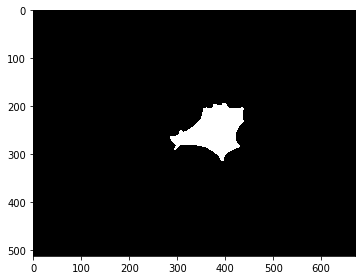

In [ ]:
imshow(mask[:,:,0])

In [ ]:
len(imagenames)

42

In [ ]:
#PREPARE MASKS AND AT THE END SAVE IN A DIFFERENT FOLDER
#DONE THIS WAY IN CASE WE ARE USING MASKS COMING FROM DIFFERENT TRAINING SET FOLDERS

#get only cells from combined (nuc,memb) mask
for imagename in imagenames:
  mask=imread(training_masks_folder+'/'+imagename)
  mask=mask[:,:,0]
  imsave(training_masks_folder+'/'+imagename, mask)

#rename files
for imagename in imagenames:
  os.rename(training_masks_folder+'/'+imagename,training_masks_folder+'/'+imagename[:-4]+'.TIF')

#get names of all masks
imagenames=os.listdir(training_masks_folder)

#copy individual images to maskdir
!cp {training_masks_folder}/* {maskdir}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: 110619_bleb_nuc_memb_masks/110619_Sample1_s18_t1.tif is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: 110619_bleb_nuc_memb_masks/110619_Sample1_s14_t1.tif is a low contrast image
  


In [ ]:
imagenames[0]

'110619_Sample1_s14_t26.TIF'

In [ ]:
#get names of all masks
imagenames=os.listdir(maskdir)

In [ ]:
#convert masks into files with only 0s and 5s in maskdir
for imagename in imagenames:
  mask=imread(maskdir+imagename)
  mask[mask>0]=5
  imsave(maskdir+imagename, mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s14_t26.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s12_t51.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s18_t1.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s15_t26.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s11_t51.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s12_t1.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


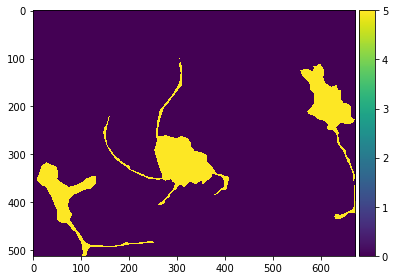

In [ ]:
mask=imread(maskdir+'/'+imagenames[1])
#hist=plt.hist(mask.ravel())
imshow(mask)

###Get and prepare images for training

In [ ]:
!gsutil cp gs://cellmbucket/110619_bleb.zip /{local_folder}

Copying gs://cellmbucket/110619_bleb.zip...
\ [1 files][426.0 MiB/426.0 MiB]                                                
Operation completed over 1 objects/426.0 MiB.                                    


In [ ]:
#this will unzip files on a folder 110619_bleb
!unzip 110619_bleb.zip

Archive:  110619_bleb.zip
   creating: 110619_bleb/
  inflating: 110619_bleb/110619_Sample1.nd  
  inflating: 110619_bleb/110619_Sample1_s10_t1.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t10.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t100.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t101.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t102.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t103.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t104.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t105.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t106.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t107.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t108.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t109.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t11.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t110.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t111.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t12.TIF  
  inflating: 110619_bleb/110

In [ ]:
imagesfolder='110619_bleb'

In [ ]:
#!cp -r /content/drive/My\ Drive/062719 /content 

In [ ]:
#%cd 062719
#!unzip 062719_sample1.zip
#!unzip 062719_sample2.zip
#%cd ..

In [ ]:
#make folder to store images for training
!mkdir imagestraining

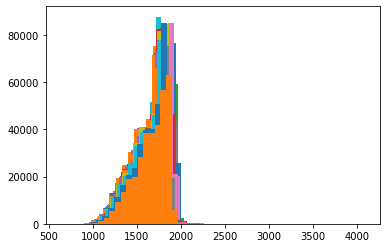

In [ ]:
for i in range(len(imagenames)):
  if imagenames[i].endswith('.TIF'):
    image=imread('/'+local_folder+'/'+ imagesfolder +'/'+imagenames[i])
    plt.hist(image.ravel(),50)

In [ ]:
#get images corresponding to masks, put them in 8 bit and rgb
for imagename in imagenames:
  bright = rescale_intensity(imread(imagesfolder+'/'+imagename),(700,2250))
  #convert to 8 bit from 16 bit
  bright8b= (bright/256).astype('uint8')
  #convert gray to rgb
  brigth8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
  imsave('./imagestraining/'+imagename, brigth8b_rgb)

In [ ]:
!ls

110619_bleb		    110619_bleb.zip  drive	     sample_data
110619_bleb_nuc_memb_masks  adc.json	     imagestraining  training_masks


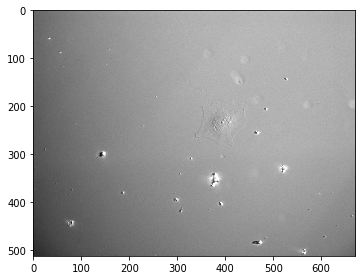

In [ ]:
image=imread('imagestraining/'+imagenames[0])
imshow(image)

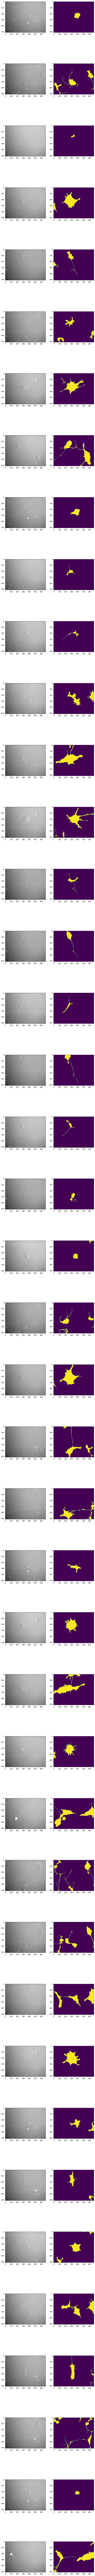

In [ ]:
f, axarr = plt.subplots(len(imagenames),2)
for i in range(len(imagenames)):
  mask=imread(maskdir+'/'+imagenames[i])
  image=imread('imagestraining/'+imagenames[i])

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)    
  f.set_size_inches(10,300)

###Prepare fast.ai data loader

In [ ]:
path=Path('/content')

In [ ]:
#codes = np.loadtxt(path/'codes.txt', dtype=str)

In [ ]:
#codes

In [ ]:
path2 = untar_data(URLs.CAMVID_TINY)

In [ ]:
codes2 = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
codes2

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
def label_func(x): return path/maskdir/f'{x.stem}.TIF'
fnames = get_image_files(path/'imagestraining')
codes = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
#dls = SegmentationDataLoaders.from_label_func(
#    path, bs=4, fnames = get_image_files(path/'imagesbrightrgb'),
#    label_func = lambda o: path/'masks'/f'{o.stem}.png',
#    codes = np.loadtxt(path2/'codes.txt', dtype=str)
    
#)

In [ ]:
#dls = SegmentationDataLoaders.from_label_func(path,fnames,label_func,bs=4,codes=codes)

In [ ]:
trainingset = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   #batch_tfms=aug_transforms(size=(512,672)))
                   batch_tfms=aug_transforms(size=(256,336)))

In [ ]:
dls = trainingset.dataloaders(path/"imagestraining", path=path, bs=8)


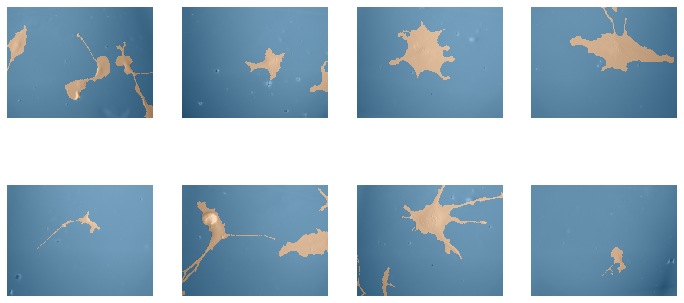

In [ ]:
dls.show_batch(max_n=10)

#Training

In [ ]:
#learn = unet_learner(dls, resnet34)
modelname='seg_cell_062719_s_1_2_110619_bleb.pkl'
!gsutil cp gs://cellmbucket/fastai_unet_models/{modelname} /{local_folder} 
loadedlearner=load_learner(modelname,cpu=True)
loadedlearner.dls=dls

Copying gs://cellmbucket/fastai_unet_models/seg_cell_062719_s_1_2_110619_bleb.pkl...
/ [1 files][217.9 MiB/217.9 MiB]                                                
Operation completed over 1 objects/217.9 MiB.                                    


In [ ]:
#learn.fine_tune(8)
loadedlearner.fine_tune(8)


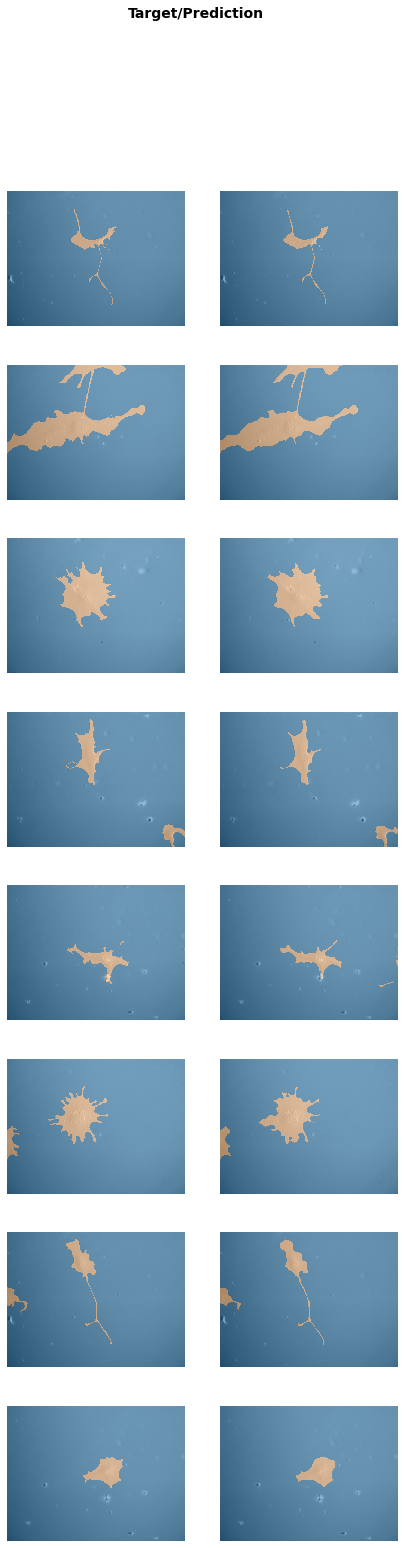

In [ ]:
loadedlearner.show_results(max_n=8, figsize=(7,25))

In [ ]:
loadedlearner.export(fname='seg_cell_062719_s_1_2_110619_bleb.pkl', pickle_protocol=2)

In [ ]:
!ls

110619_bleb		    imagestraining
110619_bleb_nuc_memb_masks  sample_data
110619_bleb.zip		    seg_cell_062719_s_1_2_110619_bleb.pkl
adc.json		    seg_nuc_062719_s_1_2_110619_bleb.pkl
drive			    training_masks


In [ ]:
!cp /content/seg_cell_062719_s_1_2_110619_bleb.pkl /content/drive/My\ Drive

# Loading a trained model

In [ ]:
#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param

In [ ]:
## ONLY CELL MODEL
modelname="seg_cell_062719_s_1_2_110619_bleb.pkl"

!gsutil cp gs://cellmbucket/fastai_unet_models/{modelname} /{local_folder}

path=Path('/content')
path2 = untar_data(URLs.CAMVID_TINY)
codes2 = np.loadtxt(path2/'codes.txt', dtype=str)
maskdir='nuclear_masks/'
def label_func(x): return path/maskdir/f'{x.stem}.TIF'
fnames = get_image_files(path/'imagestraining')
codes = np.loadtxt(path2/'codes.txt', dtype=str)
loadedlearner=load_learner(modelname,cpu=True)

Copying gs://cellmbucket/fastai_unet_models/seg_cell_062719_s_1_2_110619_bleb.pkl...
| [1 files][217.9 MiB/217.9 MiB]                                                
Operation completed over 1 objects/217.9 MiB.                                    


#Segment experiment

### Set folder names and paths

In [ ]:
#@markdown Path of the folder containing the movies in GCP bucket
movies_path="cellmbucket/05042021_ARPC2_KO/trial1/sample6"  #@param {type:"string"}
#@markdown Name of the folder that will contain the masks
foldermasks= '05042021_ARPC2_KO-masks'  #@param {type:"string"}
#@markdown path of the folder on GCP bucket where the masks will be deposited as a .zip file
dest_path='cellmbucket/05042021_ARPC2_KO/trial1/05042021_ARPC2_KO-sample6-cell-masks' #@param {type:"string"}

In [ ]:
folderimages= ntpath.basename(movies_path)

In [ ]:
foldermasks

'05042021_ARPC2_KO-masks'

In [ ]:
!mkdir {foldermasks}

### Get movies from GCP

In [ ]:
!gsutil -m cp -r gs://{movies_path} /content

Streaming output truncated to the last 5000 lines.
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t162.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t163.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t164.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t165.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t166.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t167.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t168.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t169.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1DIC_s13_t17.TIF...
Copying gs://cellmbucket/05042021_ARPC2_KO/trial1/sample6/05042021_Sample6_w1

In [ ]:
!ls

05042021_ARPC2_KO-masks  drive	  sample_data
adc.json		 sample6  seg_cell_062719_s_1_2_110619_bleb.pkl


### Get number of movies and frames per movie, find image basename

In [ ]:
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

In [ ]:
imagenames[0]

'05042021_Sample6_w1DIC_s19_t38.TIF'

In [ ]:
#Get movie numbers and show the largest number
listmovies=[int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
nmovies=max(listmovies)
movies=set(listmovies)
movies

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31}

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
nframes=max(listframes)
frames=range(1,nframes+1)
nframes

181

In [ ]:
re.findall(r"(.*)_s",imagenames[0])[0]

'05042021_Sample6_w1DIC'

In [ ]:
filenamebase='sample6' #@param {type:"string"}

### Set contrast range

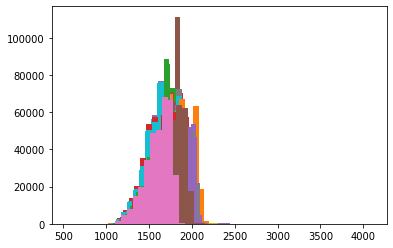

In [ ]:
imagenames=os.listdir(folderimages)
for i in range(1,len(imagenames),100):
  if imagenames[i][-3:]=='TIF':
    image=imread(folderimages + '/'+imagenames[i])
    plt.hist(image.ravel(),50)

In [ ]:
minpixelintensity=1000 #@param {type:"integer"}
maxpixelintensity=2250 #@param {type:"integer"}

###Test segmentation

In [ ]:
for i in range(1,16):
  if imagenames[i][-3:]=='TIF':
    bright = rescale_intensity(imread(filenamebase+'/'+imagenames[i]),(minpixelintensity,maxpixelintensity))
    #convert to 8 bit from 16 bit
    bright8b= (bright/256).astype('uint8')
    tosegment=np.stack((bright8b,bright8b,bright8b),axis=2)
    segmented = loadedlearner.predict(tosegment)[1]
    mask01=np.asarray(segmented)
    imsave(foldermasks+'/'+imagenames[i], mask01.astype('uint8'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t30.TIF is a low contrast image
  if __name__ == '__main__':


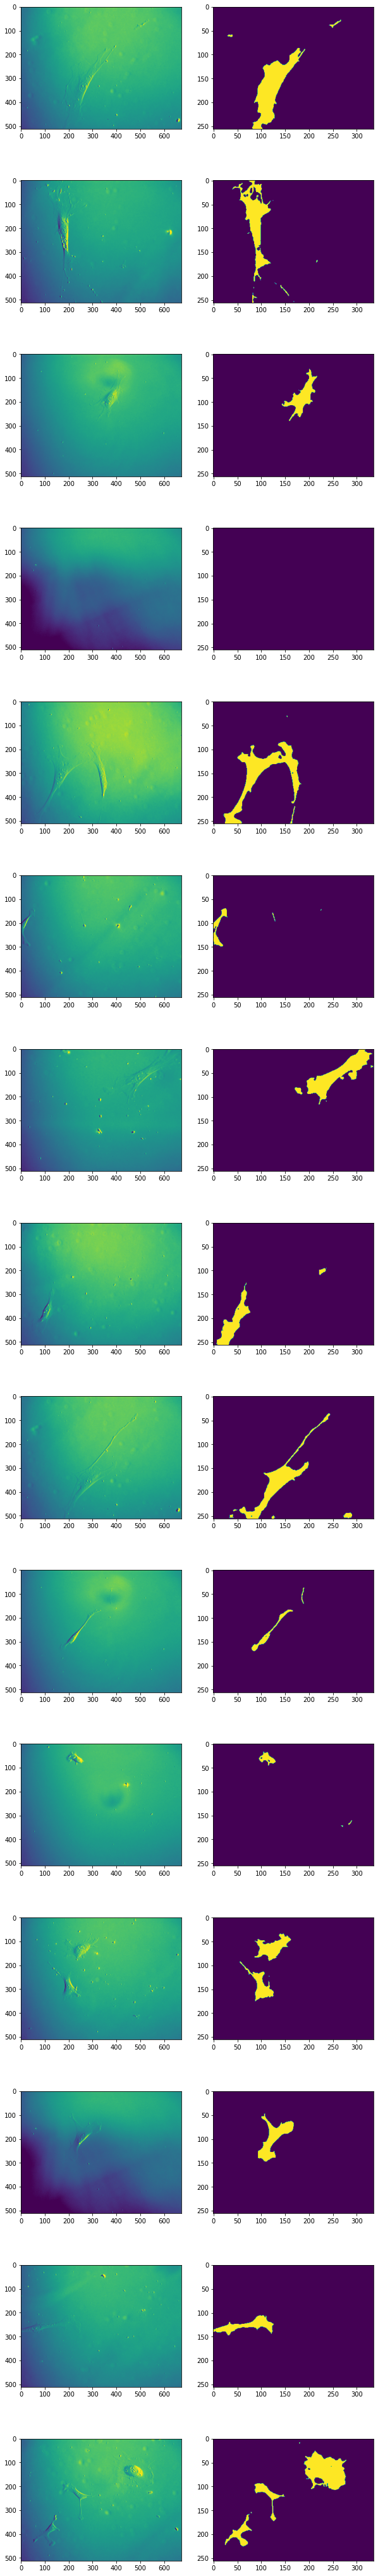

In [ ]:
masknames=os.listdir(foldermasks)
nimages=len(masknames)
f, axarr = plt.subplots(nimages,2)

for i in range(nimages):
  mask=imread(foldermasks+'/'+masknames[i])
  image=rescale_intensity(imread(folderimages+'/'+masknames[i]),(minpixelintensity,maxpixelintensity))

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)    
  f.set_size_inches(10,5*nimages)

###Segment experiment and save output

In [ ]:
for name in imagenames:
  if imagenames[i][-3:]=='TIF':
    bright = rescale_intensity(imread(filenamebase+'/'+name),(minpixelintensity,maxpixelintensity))
    #convert to 8 bit from 16 bit
    bright8b= (bright/256).astype('uint8')
    tosegment=np.stack((bright8b,bright8b,bright8b),axis=2)
    segmented = loadedlearner.predict(tosegment)[1]
    mask01=np.asarray(segmented)
    imsave(foldermasks+'/'+name, mask01.astype('uint8'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s2_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s18_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s8_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s31_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s6_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s23_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s22_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s17_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s20_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s29_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s25_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s28_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s12_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s5_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s27_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s3_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s24_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s9_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s15_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s11_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s21_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s10_t76.TIF is a low contrast image
  if __name__ == '__main__':


ValueError: ignored

In [ ]:
!zip -r {foldermasks}.zip {foldermasks}

  adding: 05042021_ARPC2_KO-masks/ (stored 0%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s19_t38.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t150.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s4_t76.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t43.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s26_t156.TIF (deflated 100%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s16_t54.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s14_t62.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s13_t120.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s7_t112.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s1_t62.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO-masks/05042021_Sample6_w1DIC_s30_t135.TIF (deflated 99%)
  adding: 05042021_ARPC2_KO

In [ ]:
!gsutil -m cp /content/{foldermasks}.zip gs://{dest_path}  

Copying file:///content/05042021_ARPC2_KO-masks.zip [Content-Type=application/zip]...
-
Operation completed over 1 objects/747.4 KiB.                                    
